In [1]:
import os
import torch
import torchvision
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import json
import numpy as np
import matplotlib as plt
from vis_utils import *
from model_def import *
from model_train import *
from net_reduce import *
import numpy as np

plt.rcParams.update({'font.size': 20})

% matplotlib inline

In [4]:
def get_off_diag_simil_mat(similMat):
    similMatOffdiag = np.tril(similMat,k=-1)
    # Energies of off-diagonal entries
    # fk, axarr = plt.subplots(nrows=3,ncols=1)
    sz = similMat.shape
    idxOffdiag = np.tril_indices(sz[0],k=-1) # lower triangular matrix below diagonal
    valOffdiag = similMatOffdiag[idxOffdiag]
    return valOffdiag

## MLP

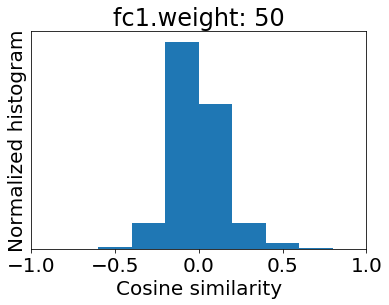

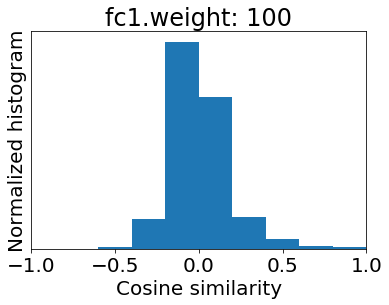

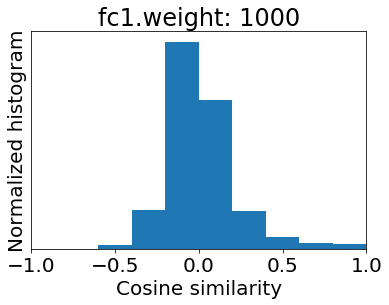

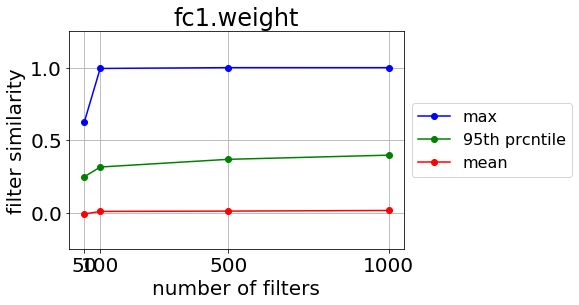

In [10]:
# Plot similarity between filters
plt.rcParams.update({'font.size': 20})

# change settings here:
numFilter = [50, 100, 500, 1000]
expRoot = 'cifar-mlp-v1_w1-'
PARAM_NAME = 'fc1.weight' # TODO

# weightSimilMat = []
maxSimil = []
meanSimil = []
prcntSimil = []

outDir = os.path.join('./data', 'figures', 'mlp-v1-simil')
if not os.path.exists(outDir):
    os.makedirs(outDir)

for idx,i in enumerate(numFilter):
    
    expFolder = os.path.join('data', expRoot+str(i))
    
    # Similarity of conv1 filters
    
    # load network
    modelPath = os.path.join(expFolder, 'net-trained.dat')
    w1 = i
    w2 = 100
    net = MLP(input_dim=3072, fc1_dim=w1, fc2_dim=w2)
    net.load_state_dict(torch.load(modelPath))
    
    # get similarity matrix of conv1 filters
    similMat, w = get_layer_cosine_similarity(net, PARAM_NAME)
    valOffdiag = get_off_diag_simil_mat(similMat) # off-diagonal elements
    
    # get metrics
    maxOffdiag = np.max(valOffdiag)
    percentileOffdiag = np.percentile(valOffdiag, 95)
    meanOffdiag = np.mean(valOffdiag)
    
    maxSimil = np.append(maxSimil, maxOffdiag)
    meanSimil = np.append(meanSimil, meanOffdiag)
    prcntSimil = np.append(prcntSimil, percentileOffdiag)
    
    # make histogram
    fig = plt.figure()
    plt.hist(valOffdiag, range=[-1,1])
    plt.xlim([-1, 1])
    plt.yticks([])
    plt.xlabel('Cosine similarity')
    plt.ylabel('Normalized histogram')
    plt.title('%s: %d' % (PARAM_NAME, w1))
    fig.savefig(\
        os.path.join(outDir, 'simil-hist%s-%d.png' % (PARAM_NAME, w1)), \
        bbox_inches='tight')
    fig.savefig(\
        os.path.join(outDir, 'simil-hist%s-%d.pdf' % (PARAM_NAME, w1)), \
        bbox_inches='tight')

    
# plotting
f = plt.figure()
nf = numFilter
plt.plot(nf, maxSimil, 'bo-', label='max')
plt.plot(nf, prcntSimil, 'go-', label='95th prcntile')
plt.plot(nf, meanSimil, 'ro-', label='mean')
plt.xlabel('number of filters')
plt.ylabel('filter similarity')
plt.xticks(nf)
plt.title(PARAM_NAME)
plt.ylim([-0.25, 1.25])

# plt.title('Filter similarity with conv-1 layer size')
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),prop={'size':16})
# plt.legend(loc='upper right')
f.savefig(os.path.join(outDir, 'simil-numfilters-%s.png' % PARAM_NAME), \
          bbox_inches='tight')
f.savefig(os.path.join(outDir, 'simil-numfilters-%s.pdf' % PARAM_NAME), \
          bbox_inches='tight')
    
    
    

## CNN

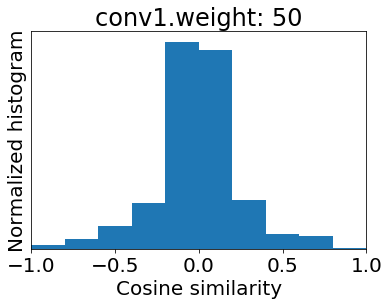

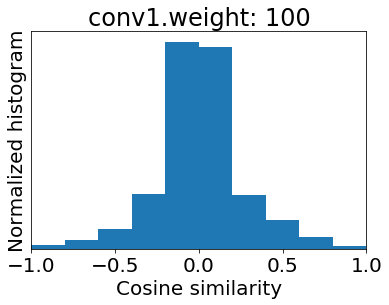

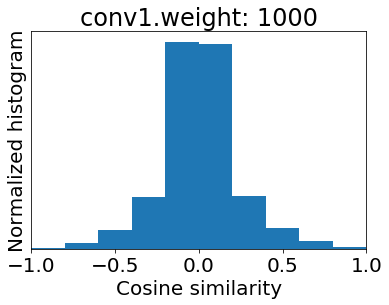

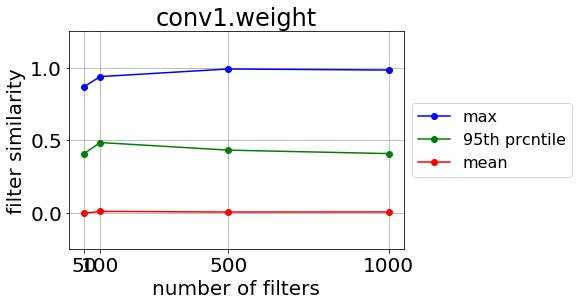

In [9]:
# Plot Conv1 similarity matrix and cosine-distance between filters
plt.rcParams.update({'font.size': 20})

# change settings here:
numFilter = [50, 100, 500, 1000]
expRoot = 'cifar-lenet-v1_w1-'
PARAM_NAME = 'conv1.weight' # TODO

# weightSimilMat = []
maxSimil = []
meanSimil = []
prcntSimil = []

outDir = os.path.join('./data', 'figures', 'lenet-v1-simil')
if not os.path.exists(outDir):
    os.makedirs(outDir)

for numF in numFilter:
    
    expFolder = os.path.join('data', expRoot+str(numF))
    
    # Similarity of conv1 filters
    
    # load network
    modelPath = os.path.join(expFolder, 'net-trained.dat')
    w1 = numF
    w2 = 50
    net = NetWide(conv1_num_filter=w1, conv2_num_filter=w2)
    net.load_state_dict(torch.load(modelPath))
    
    
    # get similarity matrix of conv1 filters
    similMat, w = get_layer_cosine_similarity(net, PARAM_NAME)
    valOffdiag = get_off_diag_simil_mat(similMat)
    
    # get metrics
    maxOffdiag = np.max(valOffdiag)
    percentileOffdiag = np.percentile(valOffdiag, 95)
    meanOffdiag = np.mean(valOffdiag)
    
    maxSimil = np.append(maxSimil, maxOffdiag)
    meanSimil = np.append(meanSimil, meanOffdiag)
    prcntSimil = np.append(prcntSimil, percentileOffdiag)
    
    # make histogram
    fig = plt.figure()
    plt.hist(valOffdiag, normed=True, range=[-1,1])
    plt.xlim([-1, 1])
    plt.yticks([])
    plt.title('w1: %d' % w1)
    plt.xlabel('Cosine similarity')
    plt.ylabel('Normalized histogram')
    plt.title('%s: %d' % (PARAM_NAME, w1))
    fig.savefig(\
        os.path.join(outDir, 'simil-hist%s-%d.png' % (PARAM_NAME, w1)), \
        bbox_inches='tight')
    fig.savefig(\
        os.path.join(outDir, 'simil-hist%s-%d.pdf' % (PARAM_NAME, w1)), \
        bbox_inches='tight')

    
# plotting
f = plt.figure()
nf = numFilter
plt.plot(nf, maxSimil, 'bo-', label='max')
plt.plot(nf, prcntSimil, 'go-', label='95th prcntile')
plt.plot(nf, meanSimil, 'ro-', label='mean')

plt.xlabel('number of filters')
plt.ylabel('filter similarity')
plt.xticks(nf)
plt.title(PARAM_NAME)
plt.ylim([-0.25, 1.25])

# plt.title('Filter similarity with conv-1 layer size')
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),prop={'size':16})
# plt.legend(loc='upper right')

f.savefig(os.path.join(outDir, 'simil-numfilters-%s.png' % PARAM_NAME), \
          bbox_inches='tight')
f.savefig(os.path.join(outDir, 'simil-numfilters-%s.pdf' % PARAM_NAME), \
          bbox_inches='tight') 
    
    

## Plot similarity by number of filter groups

A measure of how similar filters in a layer are can be obtained by looking at the ratio of filter groups and the total number of filters.

We plot this for the first layer of the MLP and the CNN.

### MLP

In [4]:
plt.rcParams.update({'font.size': 20})

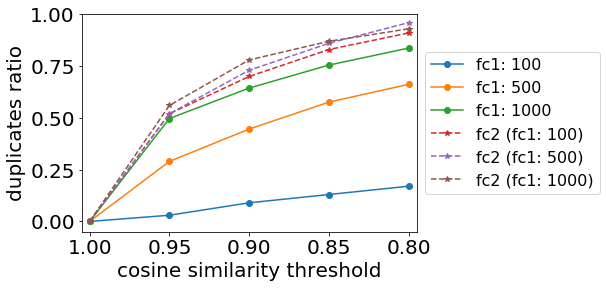

In [21]:
# from matplotlib.font_manager import FontProperties

# fontP = FontProperties()
# fontP.set_size('small')
# # legend([plot1], "title", prop=fontP)


outDir = os.path.join('./data', 'figures', 'mlp-v1-simil')
f = plt.figure()

# for fc1 layer
thresh = [1, 0.95, 0.9, 0.85, 0.8]
fc1_sizes = [100.0, 500.0, 1000.0]
fc1_num_filters = np.asarray([[100, 97, 91, 87, 83],
                   [500, 355, 277, 212, 169], 
                   [1000, 503, 356, 245, 163]
                   ])

for nf_fc1, num_fc1 in zip(fc1_num_filters,fc1_sizes):
    compression_fc1 = (np.asarray(nf_fc1))/num_fc1
    
    plt.plot(thresh, 1-compression_fc1, 'o-', label='fc1: %d' % num_fc1)

    plt.ylabel('num(filter groups)/num(filters)')
    plt.xlabel('cosine similarity threshold')
    plt.ylim([0,1])
    plt.legend(loc='lower right')
    
# for fc2 layer
thresh_fc2 = [1, 0.95, 0.9, 0.85, 0.8]
fc1_sizes = [100.0, 500.0, 1000.0]
fc2_num_filters = np.asarray([[100, 48, 30, 17, 9],
                   [100, 48, 27, 14, 4], 
                   [100, 44, 22, 13, 7]
                   ])
for nf_fc1, num_fc1 in zip(fc2_num_filters,fc1_sizes):
    compression_fc1 = (np.asarray(nf_fc1))/100.0
    
    plt.plot(thresh, 1-compression_fc1, '*--', label='fc2 (fc1: %d)' % num_fc1)

    plt.ylabel('duplicates ratio')
    plt.xlabel('cosine similarity threshold')
    plt.ylim([-0.05,1])
    plt.xlim([1.005, 0.795])
# plt.legend(loc='lower right', prop=fontP)
# plt.legend(loc='lower right')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),prop={'size':16})
    
f.savefig(os.path.join(outDir,'simil-mlp-fc1.pdf'), bbox_inches='tight')
f.savefig(os.path.join(outDir,'simil-mlp-fc1.png'), bbox_inches='tight')   
    

### CNN

In [19]:
outDir = os.path.join('./data', 'figures', 'lenet-v1-simil')
thresh = [1, 0.95, 0.9, 0.85, 0.8]

num_w1 = 100.0
num_filters_100 = np.asarray([100, 100, 98, 86, 81])
compression_100 = (np.asarray(num_filters_100))/num_w1

num_w1 = 500.0
num_filters_500 = np.asarray([500, 500, 425, 339, 239])
compression_500 = (np.asarray(num_filters_500))/num_w1

num_w1 = 1000.0
num_filters_1000 = np.asarray([1000, 1000, 858, 647, 441])
compression_1000 = (np.asarray(num_filters_1000))/num_w1

f = plt.figure()
plt.plot(thresh, 1-compression_100, 'o-', label='conv1: 100')
plt.plot(thresh, 1-compression_500, 'o-', label='conv1: 500')
plt.plot(thresh, 1-compression_1000, 'o-', label='conv1: 1000')
plt.ylabel('duplicates ratio')
plt.xlabel('cosine similarity threshold')
plt.ylim([-0.05,1])
plt.xlim([1.005, 0.795])
plt.legend(loc='upper left')
f.savefig(os.path.join(outDir,'simil-cnn-conv1.pdf'), bbox_inches='tight')
f.savefig(os.path.join(outDir,'simil-cnn-conv1.png'), bbox_inches='tight')

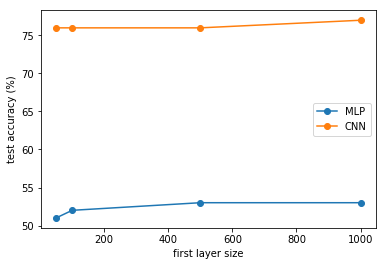

In [132]:
# Plotting accuracy with increasing first layer size
outDir = os.path.join('./data', 'figures')
num_filter = [50, 100, 500, 1000]

# mlp
acc_mlp = [51, 52, 53, 53]

# cnn
acc_cnn = [76, 76, 76, 77]

# plotting
f = plt.figure()
plt.plot(num_filter, acc_mlp, 'o-', label='MLP')
plt.plot(num_filter, acc_cnn, 'o-', label='CNN')
plt.xlabel('first layer size')
plt.ylabel('test accuracy (%)')
plt.legend()
f.savefig(os.path.join(outDir,'accuracy-filters.png'), bbox_inches='tight')
f.savefig(os.path.join(outDir,'accuracy-filters.pdf'), bbox_inches='tight')

## Initializations of similar filters

In [5]:
# specify settings
num_first_layer = 500
expName = 'cifar-mlp-v1_w1-%d' % num_first_layer
w1 = num_first_layer # change conv1 dim
w2 = 100
expDir = os.path.join('./data', expName)
LAYER_CURR = 'fc1'


# output dir
outDir =  os.path.join(expDir, 'simil_training')
if not os.path.exists(outDir):
    os.makedirs(outDir)


# for MLP - at init.
net = MLP(input_dim=3072, fc1_dim=w1, fc2_dim=w2)
net._init_weights(init_sigma=0.003) # init using Gaussians
# net.load_state_dict(torch.load(os.path.join(expDir, 'net-trained.dat')))
print net

MLP (
  (fc1): Linear (3072 -> 500)
  (fc2): Linear (500 -> 100)
  (fc3): Linear (100 -> 10)
)


In [6]:
# plot filter similarity at init.
net.cpu()
similMat, _ = get_layer_cosine_similarity(net, LAYER_CURR+'.weight')

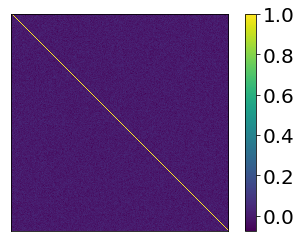

In [19]:
f = plt.figure()
plt.imshow(similMat)
plt.colorbar()
plt.xticks([])
plt.yticks([])
f.savefig(os.path.join(outDir,'mlp-epoch_-1.pdf'), bbox_inches='tight')
f.savefig(os.path.join(outDir,'mlp-epoch_-1.png'), bbox_inches='tight')

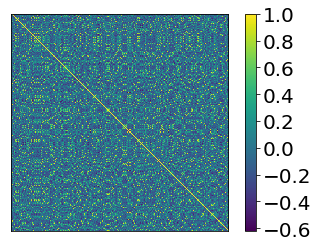

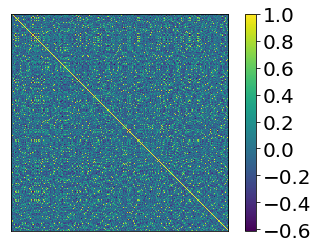

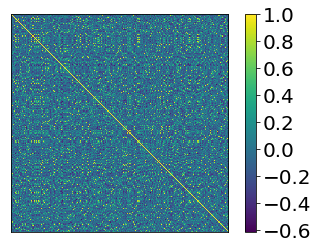

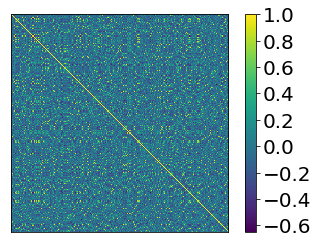

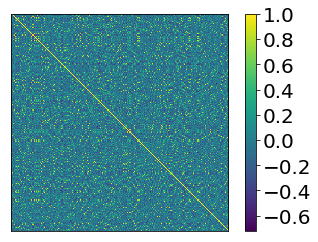

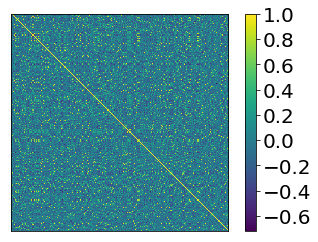

In [25]:
# plot similarity matrix over training epochs

for i in xrange(10):
    chkpt_path = os.path.join(expDir, 'checkpoints', 'net-epoch-%03d.dat' % i)
    net.load_state_dict(torch.load(chkpt_path))
    
    net.cpu()
    similMat, _ = get_layer_cosine_similarity(net, LAYER_CURR+'.weight')
    
    f = plt.figure()
    plt.imshow(similMat)
    plt.colorbar()
    plt.xticks([])
    plt.yticks([])
    f.savefig(os.path.join(outDir,'mlp-epoch_%d.pdf' % i), bbox_inches='tight')
    f.savefig(os.path.join(outDir,'mlp-epoch_%d.png' % i), bbox_inches='tight')
  



In [11]:
batch_loss = np.loadtxt(os.path.join('data/cifar-mlp-v2_w1-500/', 'train-batch.log'))

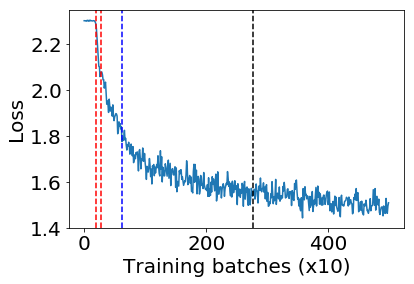

In [35]:
f = plt.figure()
plt.rcParams.update({'font.size': 20})
plt.plot(batch_loss)
plt.axvline(x=19, color='r', linestyle='--')
plt.axvline(x=27, color='r', linestyle='--')
plt.axvline(x=62, color='b', linestyle='--')
plt.axvline(x=276, color='k', linestyle='--')
plt.ylabel('Loss')
plt.xlabel('Training batches (x10)')
f.savefig(os.path.join(outDir,'batch-loss.pdf'), bbox_inches='tight')
f.savefig(os.path.join(outDir,'batch-loss.png'), bbox_inches='tight')

In [30]:
outDir

'./data/cifar-mlp-v1_w1-500/simil_training'